In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# 데이터 로드
train = pd.read_csv('../open/train.csv')

# 데이터 전처리 (Pivot 생성)
monthly = train.groupby(["item_id", "year", "month"], as_index=False)["value"].sum()
monthly["ym"] = pd.to_datetime(monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2))
pivot = monthly.pivot(index="item_id", columns="ym", values="value").fillna(0.0)

print("데이터 로드 및 피벗 완료:", pivot.shape)

데이터 로드 및 피벗 완료: (100, 43)


In [2]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    print("공행성 쌍 탐색 시작...")
    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                # x를 lag만큼 앞서게 함 (x[:-lag] vs y[lag:])
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# 실행
pairs = find_comovement_pairs(pivot)
print("탐색된 공행성쌍 수:", len(pairs))
pairs.head()

공행성 쌍 탐색 시작...


100it [00:02, 34.24it/s]


탐색된 공행성쌍 수: 1425


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,5,-0.443984
1,AANGBULD,DEWLVASR,6,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635
3,AANGBULD,EVBVXETX,6,0.436623
4,AANGBULD,FTSVTTSR,3,0.531400


In [3]:
def make_base_features(pivot):
    """
    모든 아이템에 대해 시계열 피처(Lags, Rolling, Calendar)와
    추세 제거(Detrending)된 Residual을 미리 계산하여 딕셔너리/DF로 반환
    """
    # 1. Long Format 변환
    df_long = pivot.stack().reset_index()
    df_long.columns = ['item_id', 'ym', 'value']
    df_long = df_long.sort_values(['item_id', 'ym']).reset_index(drop=True)
    
    # 2. Detrending (Linear Regression)
    trends = {}
    residuals = []
    
    print("1. Detrending 및 기본 피처 생성 중...")
    for item in tqdm(df_long['item_id'].unique()):
        item_df = df_long[df_long['item_id'] == item]
        
        # 선형 추세 학습
        X_trend = np.arange(len(item_df)).reshape(-1, 1)
        y_trend = item_df['value'].values
        
        lr = LinearRegression()
        lr.fit(X_trend, y_trend)
        trends[item] = lr
        
        # Residual 계산
        trend_pred = lr.predict(X_trend)
        resid = y_trend - trend_pred
        residuals.extend(resid)
        
    df_long['residual'] = residuals
    
    # 3. Rolling & Lag Features (Item별 GroupBy)
    # 주의: 여기서 만드는 피처는 'Target Item(Follower)'의 자기 자신 과거 데이터임
    groups = df_long.groupby('item_id')['value']
    
    # Lag Features
    df_long['val_lag_1'] = groups.shift(1)
    df_long['val_lag_3'] = groups.shift(3)
    
    # Rolling Features (Shift(1) 적용하여 Data Leakage 방지)
    df_long['roll_mean_3'] = groups.shift(1).rolling(3).mean()
    df_long['roll_mean_6'] = groups.shift(1).rolling(6).mean()
    df_long['roll_std_6'] = groups.shift(1).rolling(6).std()
    
    # Calendar Features
    df_long['month'] = df_long['ym'].dt.month
    df_long['sin_month'] = np.sin(2 * np.pi * df_long['month'] / 12)
    df_long['cos_month'] = np.cos(2 * np.pi * df_long['month'] / 12)
    
    return df_long, trends

def build_advanced_dataset(pairs, df_base, pivot):
    """
    Pairs 정보를 기반으로 학습 데이터셋 구축
    Feature: Follower의 기본 피처 + Leader의 Lagged Value (Exogenous)
    Target: Follower의 Residual
    """
    print("2. Pair 기반 학습 데이터셋 병합 중...")
    
    # df_base를 검색하기 쉽게 인덱싱
    df_base_idx = df_base.set_index(['item_id', 'ym'])
    
    train_rows = []
    
    # pivot을 딕셔너리로 변환하여 접근 속도 향상 (Leader 값 조회용)
    pivot_dict = pivot.T.to_dict('list')
    months = pivot.columns
    n_months = len(months)
    
    for row in tqdm(pairs.itertuples(index=False), total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        
        # Leader/Follower 데이터 존재 확인
        if leader not in pivot_dict or follower not in df_base_idx.index.levels[0]:
            continue
            
        leader_values = pivot_dict[leader] # 전체 시계열
        
        # 학습 기간: Lag 이후부터 ~ 마지막 달
        # t 시점의 Follower를 예측하기 위해
        # Feature: Follower(t의 features), Leader(t-lag)
        
        # Follower의 데이터 가져오기
        f_data = df_base[df_base['item_id'] == follower].copy()
        
        # Leader의 Lagged Value 매핑
        # Leader 값은 (t - lag) 시점의 값
        # Pandas 연산 속도를 위해 배열 연산 사용
        
        # 전체 길이에 대해 미리 매핑
        # f_data['ym'] 시점에 해당하는 leader의 인덱스를 찾아야 함.
        # 간단하게: leader_values 배열을 lag 만큼 shift해서 붙임
        
        # leader_values: [v0, v1, ..., v_last]
        # shifted: [NaN, NaN, v0, v1, ...] (lag만큼 밈)
        shifted_leader = np.array([np.nan]*len(leader_values))
        if lag < len(leader_values):
            shifted_leader[lag:] = leader_values[:-lag]
            
        f_data['leader_lagged_value'] = shifted_leader
        f_data['max_corr'] = corr
        f_data['best_lag'] = lag
        
        # 결측치(Lag로 인한 앞부분) 제거
        f_data = f_data.dropna()
        
        train_rows.append(f_data)
        
    # 전체 병합
    if len(train_rows) > 0:
        df_train = pd.concat(train_rows, axis=0)
        return df_train
    else:
        return pd.DataFrame()

# 실행
df_base_features, item_trends = make_base_features(pivot)
df_train_adv = build_advanced_dataset(pairs, df_base_features, pivot)

print(f"생성된 심화 학습 데이터 Shape: {df_train_adv.shape}")
df_train_adv.head()

1. Detrending 및 기본 피처 생성 중...


100%|██████████| 100/100 [00:00<00:00, 1207.12it/s]


2. Pair 기반 학습 데이터셋 병합 중...


100%|██████████| 1425/1425 [00:02<00:00, 660.14it/s]


생성된 심화 학습 데이터 Shape: (52725, 15)


,item_id,ym,value,residual,val_lag_1,val_lag_3,roll_mean_3,roll_mean_6,roll_std_6,month,sin_month,cos_month,leader_lagged_value,max_corr,best_lag
135,APQGTRMF,2022-07-01,759980.0,355442.048475,582317.0,470398.0,530862.666667,451077.333333,133082.564001,7,-0.500000,-8.660254e-01,52347.0,-0.443984,5
136,APQGTRMF,2022-08-01,216019.0,-178696.964059,759980.0,539873.0,627390.000000,513740.833333,176587.606294,8,-0.866025,-5.000000e-01,53549.0,-0.443984,5
137,APQGTRMF,2022-09-01,537693.0,152799.023407,216019.0,582317.0,519438.666667,464275.166667,214416.524353,9,-1.000000,-1.836970e-16,0.0,-0.443984,5
138,APQGTRMF,2022-10-01,205326.0,-169745.989127,537693.0,759980.0,504564.000000,517713.333333,177209.040946,10,-0.866025,5.000000e-01,26997.0,-0.443984,5
139,APQGTRMF,2022-11-01,169440.0,-195810.001661,205326.0,216019.0,319679.333333,473534.666667,219386.325323,11,-0.500000,8.660254e-01,84489.0,-0.443984,5


Train: (48450, 15), Valid: (4275, 15)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	training's rmse: 2.34507e+06	valid_1's rmse: 3.98639e+06


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

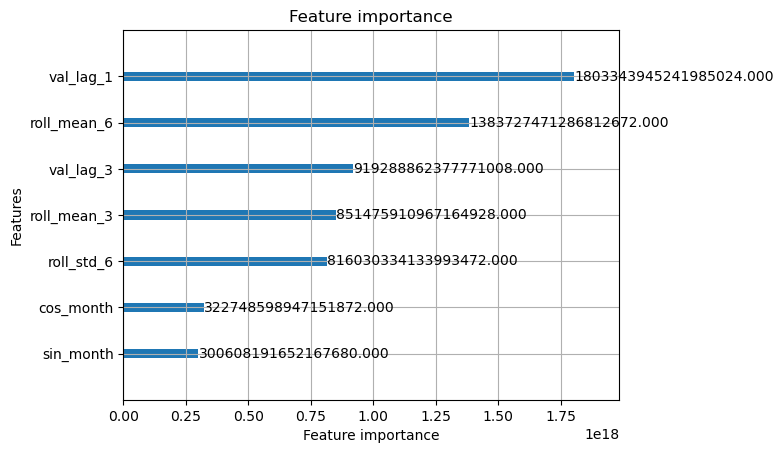

In [4]:
# Feature 정의
features_col = [
    'val_lag_1', 'val_lag_3', 
    'roll_mean_3', 'roll_mean_6', 'roll_std_6',
    'sin_month', 'cos_month',
    'leader_lagged_value', # 핵심: Leader의 선행 지표
    'max_corr', 'best_lag' # 관계 정보
]
target_col = 'residual'

# 학습/검증 분리 (마지막 3개월)
cutoff_date = df_train_adv['ym'].max() - pd.DateOffset(months=3)
train_set = df_train_adv[df_train_adv['ym'] <= cutoff_date]
valid_set = df_train_adv[df_train_adv['ym'] > cutoff_date]

print(f"Train: {train_set.shape}, Valid: {valid_set.shape}")

# Dataset 생성
dtrain = lgb.Dataset(train_set[features_col], label=train_set[target_col])
dvalid = lgb.Dataset(valid_set[features_col], label=valid_set[target_col])

# 파라미터 (Regression)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'seed': 42,
    'verbosity': -1
}

model = lgb.train(
    params, 
    dtrain, 
    num_boost_round=1000, 
    valid_sets=[dtrain, dvalid],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# 중요도 시각화
lgb.plot_importance(model, max_num_features=10, importance_type='gain')

In [5]:
def predict_pairs_202508(pairs, pivot, df_base, model, trends, features_col):
    target_ym = pd.to_datetime('2025-08-01') # 예측 목표: 2025-08 (가정)
    # 실제로는 pivot의 마지막 날짜 + n 이지만 여기선 2025-08로 고정하여 feature 생성
    
    preds = []
    pivot_dict = pivot.T.to_dict('list')
    
    # 2025-08 예측을 위한 Follower들의 Feature 준비
    # df_base에는 2025-07까지 있음. Rolling/Lag를 위해 한 줄 추가 필요할 수 있음
    # 여기서는 간단히 2025-07 시점의 통계량이나 Lag를 Shift해서 직접 계산
    
    print("예측 진행 중...")
    for row in tqdm(pairs.itertuples(index=False), total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        
        if leader not in pivot_dict: 
            continue
            
        # 1. Leader Feature (Exogenous)
        # 2025-08 기준 lag개월 전 값
        # pivot 컬럼 인덱스상 어디인지 확인
        # 현재 pivot의 마지막은 2025-07
        # 2025-08은 index = len(pivot.columns)
        # 가져올 index = len - lag
        
        leader_vals = pivot_dict[leader]
        idx_leader = len(leader_vals) - lag # 2025-08 index(가상) - lag
        
        if idx_leader < 0: 
            # lag가 너무 길어 데이터가 없는 경우
            leader_val = 0 
        else:
            leader_val = leader_vals[idx_leader]
            
        # 2. Follower Base Features (Rolling, Lag)
        # df_base에서 follower의 가장 최근(2025-07) 행을 가져와서
        # 다음 달(2025-08) 피처로 변환해야 함 (예: Lag1 -> 7월값)
        f_last_row = df_base[df_base['item_id'] == follower].iloc[-1]
        
        # Feature 구성
        input_row = {
            'val_lag_1': f_last_row['value'],      # 8월의 lag1은 7월 value
            'val_lag_3': pivot_dict[follower][-3], # 8월의 lag3은 5월 value (idx -2)
            'roll_mean_3': np.mean(pivot_dict[follower][-3:]),
            'roll_mean_6': np.mean(pivot_dict[follower][-6:]),
            'roll_std_6': np.std(pivot_dict[follower][-6:]),
            'sin_month': np.sin(2 * np.pi * 8 / 12), # 8월
            'cos_month': np.cos(2 * np.pi * 8 / 12),
            'leader_lagged_value': leader_val,
            'max_corr': corr,
            'best_lag': lag
        }
        
        # DF 변환
        X_test = pd.DataFrame([input_row])[features_col]
        
        # 3. Residual 예측
        pred_resid = model.predict(X_test)[0]
        
        # 4. Trend 복원
        # Follower의 Trend 모델 사용
        # 시간축 t: 전체 길이 + 1 (2025-08)
        t_future = len(leader_vals) 
        trend_val = trends[follower].predict([[t_future]])[0]
        
        # 최종값
        final_val = trend_val + pred_resid
        final_val = max(0, int(round(final_val))) # 음수 제거 및 정수화
        
        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": final_val
        })
        
    return pd.DataFrame(preds)

# 최종 예측 및 저장
submission = predict_pairs_202508(pairs, pivot, df_base_features, model, item_trends, features_col)
print(submission.head())
submission.to_csv('./submissions/baseline_lag_rolling_calendar_exogenous_lightgbm.csv', index=False)

예측 진행 중...


100%|██████████| 1425/1425 [00:10<00:00, 136.67it/s]


  leading_item_id following_item_id    value
0        AANGBULD          APQGTRMF        0
1        AANGBULD          DEWLVASR   318826
2        AANGBULD          DNMPSKTB  3753068
3        AANGBULD          EVBVXETX  4558731
4        AANGBULD          FTSVTTSR   152782
